# 🧠 Motor Imagery Classifier — 2 Classes (Left vs Right)

**Goal:** Train and evaluate a binary MI classifier *(left-hand vs right-hand imagery)*.

---

## 🔁 Unit of Generalization

- **Unseen runs (within-subject):**  
  - Split **by run** *inside each subject*.  
  - Train on some runs, **test on held-out runs** of the **same** subject.

- **Unseen subjects (LOSO):**  
  - Split **by subject** using `GroupKFold` / `LeaveOneGroupOut`.  
  - Train on all but one subject, **test on the held-out subject**.

> Tip: Keep `X`, `y`, and `groups` aligned so that `groups` encodes **run IDs** for within-subject splits and **subject IDs** for LOSO.

---

## 📏 Evaluation Metrics

- **Accuracy** — standard proportion of correct predictions.
- **Cohen’s κ** — chance-corrected agreement (more robust under class imbalance).

> Report **mean ± SD** across folds for both metrics.

---

## ✅ Reporting Checklist

- [ ] Clearly state whether results are for **unseen runs** or **unseen subjects**.  
- [ ] Use the **same preprocessing** in train/test (fit transformers on *train only*).  
- [ ] Preserve **group boundaries** in CV splits.  
- [ ] Report **Accuracy** and **Cohen’s κ** per fold and aggregated.  
- [ ] Include **confusion matrices** (optional but helpful).

---


In [ ]:
from pathlib import Path
import re, numpy as np, torch
import pandas as pd
import mne
from braindecode.models import EEGNet, ShallowFBCSPNet
from braindecode.util import set_random_seeds
from braindecode.datasets import create_from_mne_epochs
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.training import CroppedLoss
from torch import nn
from torch.utils.data import DataLoader

%load_ext autoreload
%autoreload 2


In [3]:
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

DATA = Path(f"{parentPath}/data")
DER  = DATA / "derivatives"  
FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(parents=True, exist_ok=True)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [12]:

paths = sorted(DER.glob("*-epo.fif"))
paths = [p for p in paths if re.search(r"R(04|08|12)", p.name)]  # L/R imagery only

In [13]:
list_of_epochs = []
runs, subjects = [], []
for p in paths:

    ep = mne.read_epochs(p, preload=True, verbose=False)

    if len(ep)==0: continue
    run = int(re.search(r"R(\d{2})", p.name).group(1)); runs.extend([run]*len(ep))
    subj_name = re.search(r"(S\d{3})", p.name).group(1); subj_number = int(subj_name.lstrip("S")); subjects.extend([subj_number] * len(ep))
    list_of_epochs.append(ep)
runs = np.array(runs); subjects = np.array(subjects)

In [14]:
# Load & prepare dataset for Braindecode models
n_times = len(list_of_epochs[0].times)  # samples per epoch
windows_dataset = create_from_mne_epochs(
    list_of_epochs,                 # API expects a list of Epochs
    window_size_samples=n_times,    # full-epoch window
    window_stride_samples=n_times,  # stride=length -> 1 window/epoch
    drop_last_window=True,          # drop incomplete window
)

In [15]:
X = np.stack([ds[0] for ds in windows_dataset]).astype(np.float32)   # (N, C, T)
meta = pd.concat([ds.windows.metadata for ds in windows_dataset.datasets], ignore_index=True)
y = meta["target"].to_numpy().astype(int)  # (N,)
y = np.asarray(y, dtype=np.int64).reshape(-1)   # CE loss expects int64 class indices
subjects = np.asarray(subjects, dtype=np.int32).reshape(-1)
runs     = np.asarray(runs, dtype=np.int32).reshape(-1)

# If your labels aren’t 0..C-1, remap them safely:
uniq = np.unique(y)
if not np.array_equal(uniq, np.arange(uniq.size)):
    remap = {old:i for i, old in enumerate(uniq)}
    y = np.vectorize(remap.get, otypes=[np.int64])(y)

# --- sanity assertions -------------------------------------------------------
N = X.shape[0]
assert y.shape == (N,) and subjects.shape == (N,) and runs.shape == (N,), "mismatched lengths"
assert X.dtype == np.float32, "X must be float32"
assert y.dtype == np.int64,   "y must be int64 for CrossEntropyLoss"
assert subjects.dtype == np.int32 and runs.dtype == np.int32
assert np.isfinite(X).all(), "X contains NaN/Inf"
assert set(np.unique(y)) == set(range(np.unique(y).size)), "labels must be contiguous 0..C-1"

# --- quick summary print -----------------------------------------------------
for name, arr in {"X": X, "y": y, "subjects": subjects, "runs": runs}.items():
    print(f"{name:8s} | shape: {arr.shape}, dtype: {arr.dtype}, "
          f"min/max: {np.min(arr):.3g}/{np.max(arr):.3g}" if arr.ndim==1 else
          f"{name:8s} | shape: {arr.shape}, dtype: {arr.dtype}")


X        | shape: (199, 64, 161), dtype: float32
y        | shape: (199,), dtype: int64, min/max: 0/1
subjects | shape: (199,), dtype: int32, min/max: 1/16
runs     | shape: (199,), dtype: int32, min/max: 4/12


In [16]:
# === Step 3: Fast baseline on unseen subjects ===============================
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score
from braindecode.models import EEGNet
from braindecode.classifier import EEGClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EarlyStopping, LRScheduler
import torch
import torch.nn as nn
import numpy as np

# infer shapes
n_ch, n_t = X.shape[1], X.shape[2]
n_classes = int(np.unique(y).size)

def build_eegnet_baseline():
    """Reasonable default EEGNet for a quick smoke test."""
    return EEGNet(
        n_chans=n_ch,
        n_outputs=n_classes,
        n_times=n_t,
        F1=8,              # temporal filters
        D=2,               # depth multiplier
        drop_prob=0.25,    # light regularization
    )

def make_eeg_clf(module):
    """Wrap module with skorch for training + tiny internal val split
    (used only for EarlyStopping/LR scheduling, not for test)."""
    return EEGClassifier(
        module=module,
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        batch_size=32,
        max_epochs=30,
        device="cuda" if torch.cuda.is_available() else "cpu",
        train_split=ValidSplit(0.2, stratified=False, random_state=42),
        callbacks=[
            ('es', EarlyStopping(patience=5, monitor='valid_loss')),
            ('lr', LRScheduler('ReduceLROnPlateau', monitor='valid_loss', patience=3)),
        ],
        classes=np.unique(y),  # ensure .classes_ is set
    )

def eval_unseen_subjects_baseline(X, y, subjects, n_splits=5):
    """GroupKFold by subject; return per-fold metrics."""
    gkf = GroupKFold(n_splits=min(n_splits, np.unique(subjects).size))
    baseline_acc = []
    for fold, (tr, te) in enumerate(gkf.split(X, y, subjects)):
        clf = make_eeg_clf(build_eegnet_baseline())
        clf.fit(X[tr], y[tr])              # train on train subjects
        yhat = clf.predict(X[te])          # test on held-out subjects
        baseline_acc.append({
            "fold": fold,
            "acc": accuracy_score(y[te], yhat),
            "kappa": cohen_kappa_score(y[te], yhat),
            "n_train": tr.size, "n_test": te.size,
        })
    return baseline_acc

baseline_acc = eval_unseen_subjects_baseline(X, y, subjects, n_splits=5)

# summarize
accs   = np.array([r["acc"] for r in baseline_acc])
kappas = np.array([r["kappa"] for r in baseline_acc])
print("EEGNet baseline (GroupKFold by subject, 5-fold)")
print(f"acc   : {accs.mean():.3f} ± {accs.std():.3f}")
print(f"kappa : {kappas.mean():.3f} ± {kappas.std():.3f}")
baseline_acc


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6812       0.4375        0.7045  0.0100  0.2133
      2        0.5618       0.4375        0.7126  0.0100  0.1898
      3        0.4955       0.4375        0.7078  0.0100  0.1995
      4        0.4321       0.4375        0.7012  0.0100  0.2213
      5        0.4153       0.4375        0.7021  0.0100  0.2005
      6        0.3795       0.4375        0.7020  0.0100  0.1957
      7        0.3245       0.4375        0.6998  0.0100  0.2002
      8        0.2374       0.4375        0.6956  0.0100  0.1932
      9        0.2174       0.5625        0.6911  0.0100  0.1963
     10        0.1929       0.4375        0.6942  0.0100  0.1933
     11        0.1794       0.4375        0.7004  0.0100  0.2018
     12        0.1498       0.4375        0.7034  0.0100  0.1994
     13        0.1309       0.4375        0.7039  0.0100  0.1942
Stopping since valid_loss

[{'fold': 0,
  'acc': 0.4878048780487805,
  'kappa': 0.0,
  'n_train': 158,
  'n_test': 41},
 {'fold': 1,
  'acc': 0.4722222222222222,
  'kappa': 0.0,
  'n_train': 163,
  'n_test': 36},
 {'fold': 2,
  'acc': 0.42857142857142855,
  'kappa': 0.0,
  'n_train': 164,
  'n_test': 35},
 {'fold': 3,
  'acc': 0.5454545454545454,
  'kappa': 0.0,
  'n_train': 155,
  'n_test': 44},
 {'fold': 4,
  'acc': 0.5116279069767442,
  'kappa': 0.0,
  'n_train': 156,
  'n_test': 43}]

In [7]:
n_ch, n_t = X_shape
set_random_seeds(seed=42, cuda=False)

# EEGNet
eegnet = EEGNet(n_ch, n_classes, n_times=n_t)
# ShallowFBCSPNet
shallow = ShallowFBCSPNet(n_ch, n_classes, n_times=n_t)


In [8]:
# Train small models
from braindecode import EEGClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EarlyStopping

device = 'cuda' if torch.cuda.is_available() else 'cpu'
eegnet_dl = EEGClassifier(
    eegnet,
    cropped=False,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=ValidSplit(cv=0.2, random_state=42),
    batch_size=32,
    max_epochs=50,
    # callbacks=[('es', EarlyStopping(patience=5))],
    device=device,
    
)
eegnet_dl.fit(windows_dataset, y=meta["target"].values)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5939       0.5068        0.6932  3.2973
      2        0.5300       0.5068        0.6943  3.3836
      3        0.5139       0.5068        0.6935  3.3309
      4        0.4987       0.5068        0.7351  3.2455
      5        0.5138       0.5068        0.6957  3.3924
      6        0.4856       0.4932        0.6934  3.3125
      7        0.4849       0.5068        0.6916  3.3265
      8        0.4805       0.4932        0.7133  3.3340
      9        0.4553       0.4932        0.7473  3.3272
     10        0.4723       0.4932        0.7560  3.3154
     11        0.4454       0.4932        1.3234  3.3261
     12        0.4393       0.4932        0.9884  3.3589
     13        0.4484       0.4932        0.9340  3.3564
     14        0.4462       0.4932        0.8087  3.3180
     15        0.4201       0.5068        2.5131  3.3800
     16        0.4372       0.5

,module,EEGNet( (en...') ) ) )
,criterion,<class 'torch...sEntropyLoss'>
,cropped,False
,callbacks,None
,iterator_train__shuffle,True
,iterator_train__drop_last,True
,aggregate_predictions,True
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.01
,max_epochs,50
,batch_size,32


In [9]:
shallow_dl = EEGClassifier(
    shallow,    
    cropped=False,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=ValidSplit(cv=0.2, random_state=42),
    batch_size=32,
    max_epochs=50,
    # callbacks=[('es', EarlyStopping(patience=5))],
    device=device,
)
shallow_dl.fit(windows_dataset, y=meta["target"].values)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.8308       0.5816        0.6834  2.8817
      2        1.1283       0.4898        1.2411  2.8376
      3        1.0057       0.5068        1.1097  3.0506
      4        0.8379       0.4932        1.6579  2.8628
      5        0.7333       0.5714        0.6996  2.8300
      6        0.6749       0.5884        0.6772  2.8711
      7        0.7767       0.5068        1.1844  2.7988
      8        0.7142       0.4864        0.9820  2.9173
      9        0.6572       0.5068        1.1366  2.8342
     10        0.6647       0.4932        1.7910  2.8813
     11        0.6650       0.4966        0.8258  2.8578
     12        0.6501       0.5408        0.7186  2.8827
     13        0.6194       0.5782        0.6822  2.8689
     14        0.6118       0.4966        1.1915  2.8182
     15        0.6046       0.5068        2.0598  2.9540
     16        0.5950       0.5

,module,ShallowFBCSPN...') ) ) )
,criterion,<class 'torch...sEntropyLoss'>
,cropped,False
,callbacks,None
,iterator_train__shuffle,True
,iterator_train__drop_last,True
,aggregate_predictions,True
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.01
,max_epochs,50
,batch_size,32


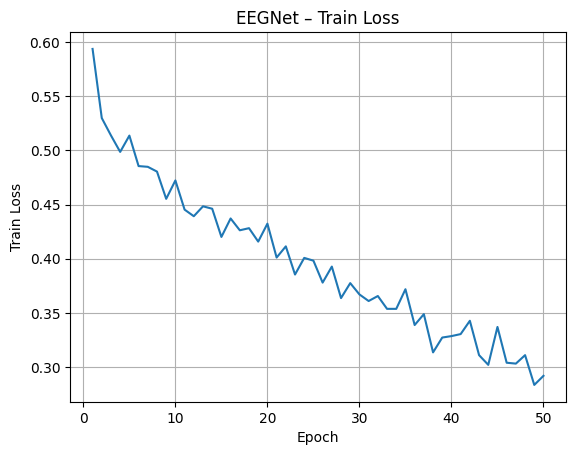

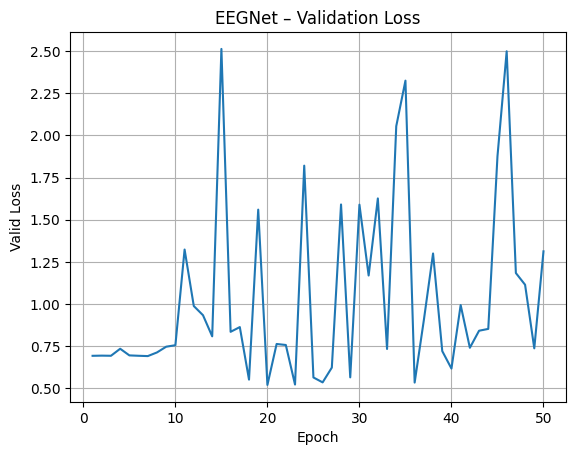

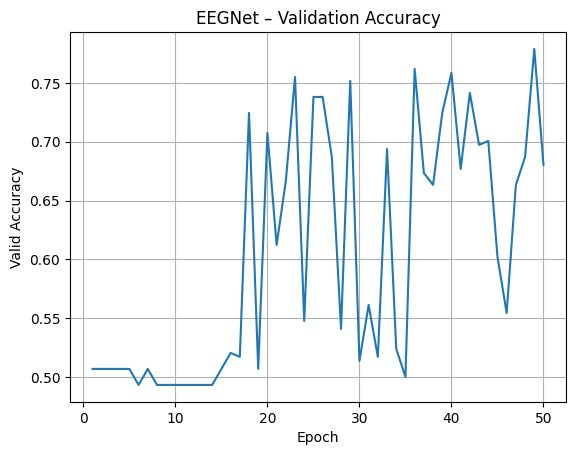

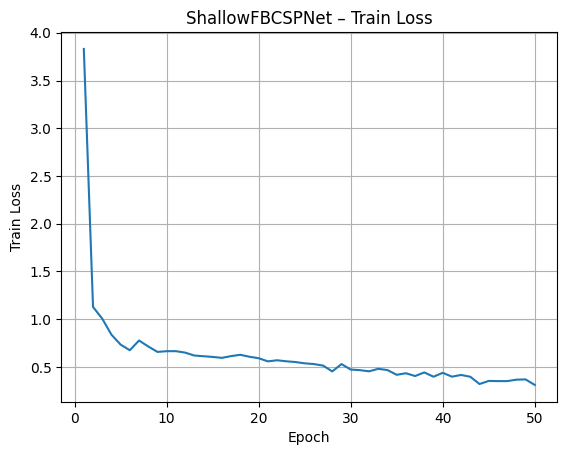

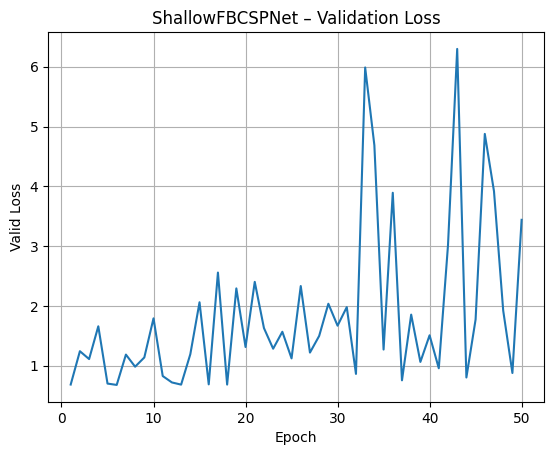

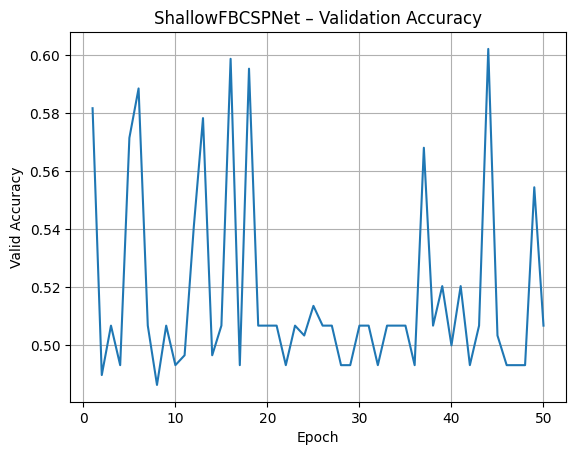

In [10]:
import matplotlib.pyplot as plt

def _as_list(h, key):
    """Return history column `key` as a python list if it exists, else None."""
    try:
        return [row[key] for row in h] if key in h[0] else None
    except Exception:
        # skorch History behaves like a list of dicts
        try:
            return h[:, key]
        except Exception:
            return None

def plot_history(clf, title_prefix="Model"):
    """
    clf: a fitted EEGClassifier (e.g., eegnet_dl or shallow_dl)
    Plots train_loss, valid_loss, valid_acc (if present).
    """
    hist = clf.history_
    epochs = _as_list(hist, "epoch")
    train_loss = _as_list(hist, "train_loss")
    valid_loss = _as_list(hist, "valid_loss")
    valid_acc  = _as_list(hist, "valid_acc")

    if epochs is None:
        print(f"{title_prefix}: no history found.")
        return

    # Train loss
    if train_loss is not None:
        plt.figure()
        plt.plot(epochs, train_loss)
        plt.xlabel("Epoch")
        plt.ylabel("Train Loss")
        plt.title(f"{title_prefix} – Train Loss")
        plt.grid(True)
        plt.show()

    # Valid loss
    if valid_loss is not None:
        plt.figure()
        plt.plot(epochs, valid_loss)
        plt.xlabel("Epoch")
        plt.ylabel("Valid Loss")
        plt.title(f"{title_prefix} – Validation Loss")
        plt.grid(True)
        plt.show()
    else:
        print(f"{title_prefix}: no validation loss (train_split=None).")

    # Valid accuracy
    if valid_acc is not None:
        plt.figure()
        plt.plot(epochs, valid_acc)
        plt.xlabel("Epoch")
        plt.ylabel("Valid Accuracy")
        plt.title(f"{title_prefix} – Validation Accuracy")
        plt.grid(True)
        plt.show()
    else:
        print(f"{title_prefix}: no validation accuracy (train_split=None).")

# Plot both models
plot_history(eegnet_dl, title_prefix="EEGNet")
plot_history(shallow_dl, title_prefix="ShallowFBCSPNet")


In [11]:
y_pred_eegnet = eegnet_dl.predict(windows_dataset)
y_pred_shallow = shallow_dl.predict(windows_dataset)
from sklearn.metrics import accuracy_score, cohen_kappa_score
print("EEGNet acc:", accuracy_score(y, y_pred_eegnet))
print("EEGNet κ:", cohen_kappa_score(y, y_pred_eegnet))
print("ShallowFBCSPNet acc:", accuracy_score(y, y_pred_shallow))
print("ShallowFBCSPNet κ:", cohen_kappa_score(y, y_pred_shallow))


EEGNet acc: 0.6950886766712142
EEGNet κ: 0.3940120845809698
ShallowFBCSPNet acc: 0.4945429740791269
ShallowFBCSPNet κ: 0.0


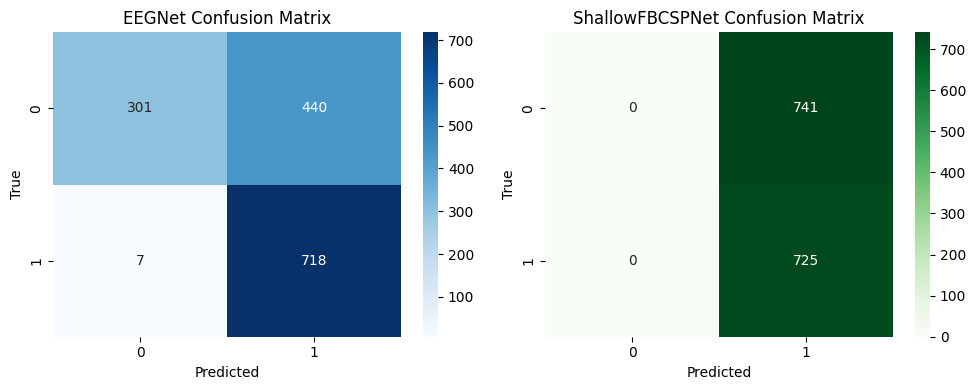

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm_eegnet = confusion_matrix(y, y_pred_eegnet)
cm_shallow = confusion_matrix(y, y_pred_shallow)
f, ax = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(cm_eegnet, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('EEGNet Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
sns.heatmap(cm_shallow, annot=True, fmt='d', ax=ax[1], cmap='Greens')
ax[1].set_title('ShallowFBCSPNet Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
plt.tight_layout()
plt.show()#savefig(FIGS / "confusion_matrices.png", dpi=300)   

In [44]:
from skorch.callbacks import LRScheduler
from torch.utils.data import Subset
def train_eval_eegnet(params, X, y, groups, n_splits=3):
    gkf = GroupKFold(n_splits=min(n_splits, np.unique(groups).size))
    rows=[]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    n_ch, n_t = windows_dataset[0][0].shape
    n_classes = int(np.unique(y).size)

    for fold,(tr,te) in enumerate(gkf.split(np.arange(len(y)), y, groups)):
        train_ds = Subset(windows_dataset, tr)
        test_ds = Subset(windows_dataset, te)

        model = EEGNet(
            n_chans=n_ch, 
            n_outputs=n_classes,
            n_times = n_t,
            F1=params["F1"], D=params["D"], drop_prob=params["dropout"])
        clf = EEGClassifier(
            model,
            criterion=nn.CrossEntropyLoss,
            optimizer=torch.optim.Adam,
            train_split=ValidSplit(0.2, stratified=False, random_state=42),
            batch_size=params["batch"],
            max_epochs=params["epochs"],
            callbacks=[('es',EarlyStopping(patience=5, monitor='valid_loss')),
                       ('lr',LRScheduler('ReduceLROnPlateau', monitor='valid_loss', patience=3))],
            device=device,
            classes=np.unique(y).astype(int))
        
        clf.fit(train_ds, y[tr])
        yhat = clf.predict(test_ds)
        acc = (yhat==y[te]).mean()
        rows.append(dict(fold=fold, acc=acc))
    return pd.DataFrame(rows)


In [42]:
X = [x[0] for x in windows_dataset]
y=meta["target"].to_numpy()#meta["target"].values
groups = subjects

In [45]:
from sklearn.model_selection import GroupKFold

param_grid = [
    {"F1":4,"D":2,"dropout":0.25,"batch":32,"epochs":40},
    {"F1":8,"D":2,"dropout":0.5,"batch":32,"epochs":40},
    {"F1":8,"D":4,"dropout":0.5,"batch":64,"epochs":50},
]
results=[]
for p in param_grid:
    df=train_eval_eegnet(p,windows_dataset,y,groups)
    results.append({**p,"acc_mean":df.acc.mean(),"acc_std":df.acc.std()})
pd.DataFrame(results)#.to_csv("../results/day7_tuning.csv",index=False)


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6301       0.4796        0.6951  0.0100  1.9629
      2        0.5287       0.4796        0.6982  0.0100  1.9946
      3        0.5281       0.4796        0.6940  0.0100  1.9291
      4        0.4922       0.4796        0.6999  0.0100  2.2950
      5        0.4798       0.4796        0.6931  0.0100  2.8361
      6        0.4861       0.4796        0.6946  0.0100  2.5745
      7        0.4599       0.4796        0.6948  0.0100  2.4122
      8        0.4484       0.4796        0.7020  0.0100  1.9178
      9        0.4458       0.4796        0.6926  0.0100  1.9547
     10        0.4388       0.5204        0.6894  0.0100  1.9086
     11        0.4316       0.5204        0.7065  0.0100  1.9551
     12        0.4361       0.5204        0.6893  0.0100  1.9369
     13        0.4222       0.5204        0.7689  0.0100  1.9318
     14        0.4007    

,F1,D,dropout,batch,epochs,acc_mean,acc_std
0,4,2,0.25,32,40,0.555204,0.105932
1,8,2,0.50,32,40,0.525210,0.041429
2,8,4,0.50,64,50,0.508873,0.006513


In [ ]:
# Leave-One-Subject-Out Evaluation with Best Hyperparameters

from sklearn.model_selection import LeaveOneGroupOut
from torch.utils.data import Subset
from skorch.dataset import ValidSplit

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# pick best params from your earlier CV
best_p = param_grid[np.argmax([r["acc_mean"] for r in results])]

# convenience
n_ch, n_t = windows_dataset[0][0].shape
classes = np.unique(y).astype(int)
n_classes = classes.size

logo = LeaveOneGroupOut()
rows = []

for tr, te in logo.split(np.arange(len(y)), y, groups):
    train_ds = Subset(windows_dataset, tr)
    test_ds  = Subset(windows_dataset, te)

    model = EEGNet(
        n_chans=n_ch,
        n_outputs=n_classes,
        n_times=n_t,
        F1=best_p["F1"],
        D=best_p["D"],
        drop_prob=best_p["dropout"],
    )

    clf = EEGClassifier(
        module=model,
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        batch_size=best_p["batch"],
        max_epochs=best_p["epochs"],
        device=device,
        train_split=ValidSplit(0.2, stratified=False, random_state=42),
        callbacks=[
            ('es', EarlyStopping(patience=5, monitor='valid_loss')),
            ('lr', LRScheduler('ReduceLROnPlateau', monitor='valid_loss', patience=3)),
        ],
        classes=classes,             # <-- correct kwarg; ensures .classes_
    )

    # IMPORTANT: pass y so skorch infers classes_ from this fold
    clf.fit(train_ds, y=y[tr])

    yhat = clf.predict(test_ds)
    acc = (yhat == y[te]).mean()

    rows.append({
        "sub_test": np.unique(groups[te])[0],
        "acc": float(acc),
    })

loso = pd.DataFrame(rows)
print(loso)
# loso.to_csv("../results/day7_loso.csv",index=False)


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6024       0.4812        0.6933  0.0100  2.9046
      2        0.5335       0.5188        0.6929  0.0100  2.9804
      3        0.5071       0.4812        0.6945  0.0100  2.7893
      4        0.5059       0.5188        0.6919  0.0100  2.7957
      5        0.4891       0.4812        0.6978  0.0100  2.7546
      6        0.4859       0.4812        0.7104  0.0100  2.9000
      7        0.4727       0.4846        0.6909  0.0100  2.8064
      8        0.4725       0.4812        0.7252  0.0100  3.0915
      9        0.4741       0.4812        0.7355  0.0100  4.7022
     10        0.4575       0.4812        0.7476  0.0100  2.8169
     11        0.4499       0.5631        0.6646  0.0100  2.7919
     12        0.4542       0.4812        0.8352  0.0100  2.9480
     13        0.4403       0.4812        0.9261  0.0100  3.4647
     14        0.4253    

In [ ]:
# Visualize learned temporal kernel of EEGNet
import matplotlib.pyplot as plt
weights = clf.module_.conv_temporal.weight.detach().cpu().numpy()[0]
plt.plot(weights[0]); plt.title("Temporal kernel – EEGNet"); plt.tight_layout()
# plt.savefig("../figs/day7_eegnet_kernel.png",dpi=150)
plt.show()
